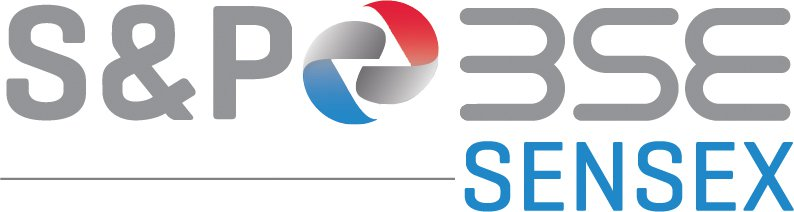

### AMAN JAIN

### Data Science & Business Analytics Internship

### GRIP - The Spark Foundation

### Task 7 -Stock Market Prediction using Numerical and Textual Analysis

##  Objective:- 
### ● Create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines
### ● Stock to analyze and predict - SENSEX (S&P BSE SENSEX).

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost 
import lightgbm

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\New\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\New\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
stock_price = pd.read_csv(r'C:\Users\New\Downloads\S&P BSE SENSEX.csv')

In [3]:
stock_headlines = pd.read_csv(r'C:\Users\New\Downloads\india-news-headlines.csv')

In [4]:
stock_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,27521.279297,27937.470703,27519.259766,27887.900391,27887.900391,7400
1,2015-01-05,27978.429688,28064.490234,27786.849609,27842.320312,27842.320312,9200
2,2015-01-06,27694.230469,27698.929688,26937.060547,26987.460938,26987.460938,14100
3,2015-01-07,26983.429688,27051.599609,26776.119141,26908.820312,26908.820312,12200
4,2015-01-08,27178.769531,27316.410156,27101.939453,27274.710938,27274.710938,8200


In [5]:
len(stock_price), len(stock_headlines)

(1345, 3424067)

In [6]:
stock_price.isna().any(), stock_headlines.isna().any()

(Date         False
 Open         False
 High         False
 Low          False
 Close        False
 Adj Close    False
 Volume       False
 dtype: bool,
 publish_date         False
 headline_category    False
 headline_text        False
 dtype: bool)

## Stock Prices

#### Dropping any null entries in our data

In [7]:
stock_price.dropna(inplace = True)

#### Dropping duplicates in data

Text(0, 0.5, 'Open')

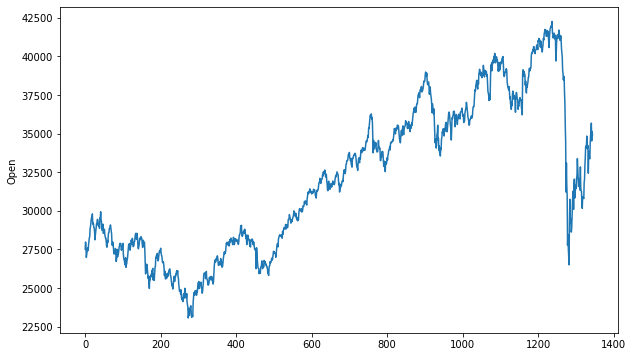

In [8]:
plt.figure(figsize=(10, 6))
stock_price['Open'].plot()
plt.ylabel('Open')

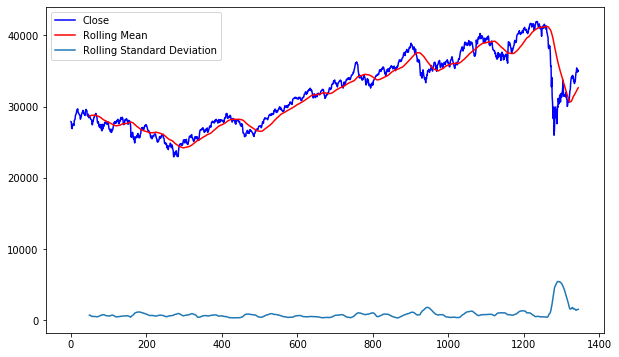

In [9]:
#Plotting moving average
close = stock_price['Close']
ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(10, 6))
stock_price['Close'].plot(color = 'b', label = 'Close')
ma.plot(color = 'r', label = 'Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')
plt.legend()

Text(0.5, 1.0, 'Returns')

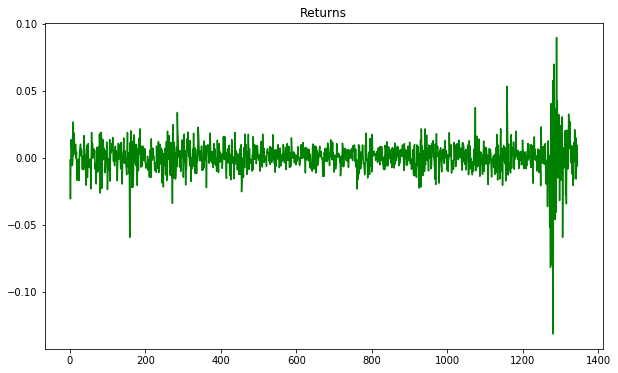

In [10]:
#Plotting returns
returns = close / close.shift(1) - 1

plt.figure(figsize = (10,6))
returns.plot(label='Return', color = 'g')
plt.title("Returns")

In [11]:
train = stock_price[:1000]
test = stock_price[1000:]

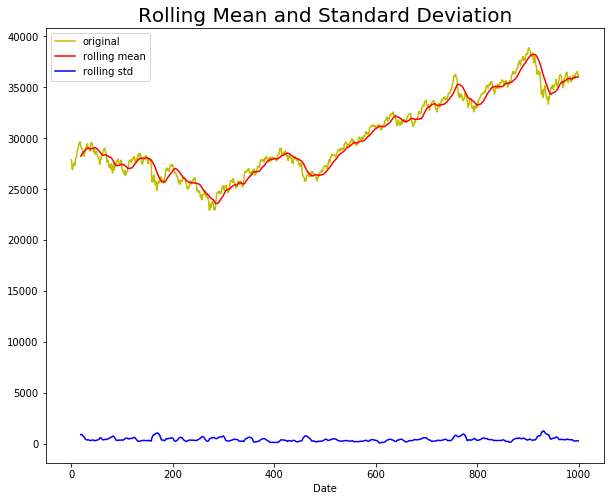

Results of dickey fuller test
ADF Test Statistic : -0.5913676380780448
p-value : 0.8729206808243516
#Lags Used : 1
Number of Observations Used : 998
Weak evidence against null hypothesis, time series is non-stationary 


In [12]:
#Stationarity test
def test_stationarity(timeseries):

 #Determing rolling statistics
 rolmean = timeseries.rolling(20).mean()
 rolstd = timeseries.rolling(20).std()

 #Plot rolling statistics:
 plt.figure(figsize = (10,8))
 plt.plot(timeseries, color = 'y', label = 'original')
 plt.plot(rolmean, color = 'r', label = 'rolling mean')
 plt.plot(rolstd, color = 'b', label = 'rolling std')
 plt.xlabel('Date')
 plt.legend()
 plt.title('Rolling Mean and Standard Deviation',  fontsize = 20)
 plt.show(block = False)
 
 print('Results of dickey fuller test')
 result = adfuller(timeseries, autolag = 'AIC')
 labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
 for value,label in zip(result, labels):
   print(label+' : '+str(value) )
 if result[1] <= 0.05:
   print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
 else:
   print("Weak evidence against null hypothesis, time series is non-stationary ")
test_stationarity(train['Close'])

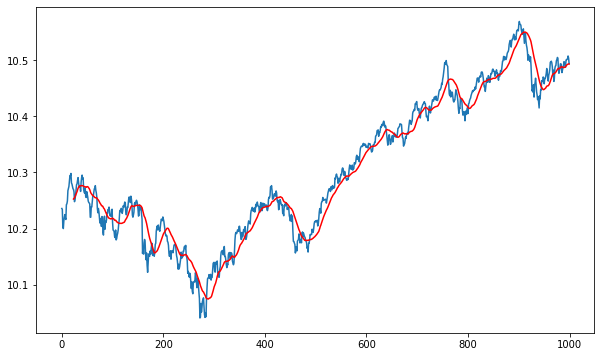

In [13]:
train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean() 
plt.figure(figsize = (10,6))
plt.plot(train_log) 
plt.plot(mav, color = 'red')

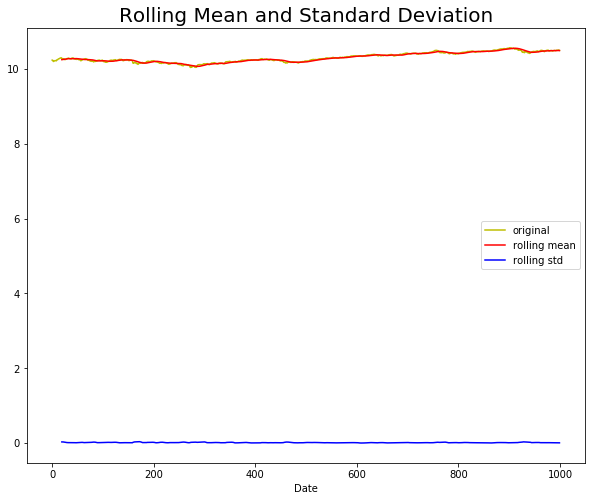

Results of dickey fuller test
ADF Test Statistic : -0.5063496560053629
p-value : 0.8907714361315964
#Lags Used : 6
Number of Observations Used : 993
Weak evidence against null hypothesis, time series is non-stationary 


In [14]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)

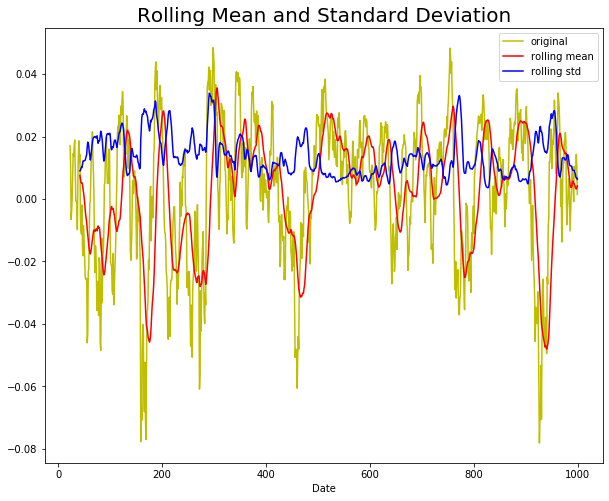

Results of dickey fuller test
ADF Test Statistic : -6.541831419707146
p-value : 9.305308782889988e-09
#Lags Used : 3
Number of Observations Used : 973
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [15]:
train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)

test_stationarity(train_log_diff)

In [16]:
cols = ['Date','Category','News']
df_news = pd.read_csv(r'C:\Users\New\Downloads\india-news-headlines.csv', names = cols)
df_news

,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa
...,...,...,...
3424063,20201231,city.jodhpur,Covid-19: Despite dip in cases; Rajasthan amon...
3424064,20201231,city.udaipur,Covid-19: Despite dip in cases; Rajasthan amon...
3424065,20201231,city.ajmer,Covid-19: Despite dip in cases; Rajasthan amon...
3424066,20201231,removed,Govt extends deadline for use of FASTag till F...


In [17]:
df_news.drop(0, inplace=True)
df_news.drop('Category', axis = 1, inplace=True)
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3424067 entries, 1 to 3424067
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Date    object
 1   News    object
dtypes: object(2)
memory usage: 78.4+ MB


In [18]:
#Converting data type of Date column 
df_news['Date'] = pd.to_datetime(df_news['Date'],format= '%Y%m%d')
df_news 

,Date,News
1,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2,2001-01-02,Fissures in Hurriyat over Pak visit
3,2001-01-02,America's unwanted heading for India?
4,2001-01-02,For bigwigs; it is destination Goa
5,2001-01-02,Extra buses to clear tourist traffic
...,...,...
3424063,2020-12-31,Covid-19: Despite dip in cases; Rajasthan amon...
3424064,2020-12-31,Covid-19: Despite dip in cases; Rajasthan amon...
3424065,2020-12-31,Covid-19: Despite dip in cases; Rajasthan amon...
3424066,2020-12-31,Govt extends deadline for use of FASTag till F...


In [19]:
#Grouping the headlines for each day
df_news['News'] = df_news.groupby(['Date']).transform(lambda x : ' '.join(x)) 
df_news = df_news.drop_duplicates() 
df_news.reset_index(inplace = True, drop = True)
df_news

,Date,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03,Powerless north India gropes in the dark Think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...
3,2001-01-05,Light combat craft takes India into club class...
4,2001-01-06,Light combat craft takes India into club class...
...,...,...
7257,2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
7258,2020-12-28,Horoscope Today; 28 December 2020: Check astro...
7259,2020-12-29,Man recovers charred remains of 'thief' from h...
7260,2020-12-30,Numerology Readings 30 December 2020: Predicti...


In [20]:
df_news['News']

0       Status quo will not be disturbed at Ayodhya; s...
1       Powerless north India gropes in the dark Think...
2       The string that pulled Stephen Hawking to Indi...
3       Light combat craft takes India into club class...
4       Light combat craft takes India into club class...
                              ...                        
7257    #BigInterview! Dhritiman Chatterjee: Nobody da...
7258    Horoscope Today; 28 December 2020: Check astro...
7259    Man recovers charred remains of 'thief' from h...
7260    Numerology Readings 30 December 2020: Predicti...
7261    Horoscope Today; 31 December 2020: Check astro...
Name: News, Length: 7262, dtype: object

In [21]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [22]:
# dropping duplicates in data
stock_price = stock_price.drop_duplicates()

# coverting the datatype of column 'Date' from type object to type 'datetime'
stock_price['Date'] = pd.to_datetime(stock_price['Date']).dt.normalize()

# filtering the important columns
stock_price = stock_price.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# setting column 'Date' as the index column
stock_price.set_index('Date', inplace= True)

# sorting the data according to Date
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price

,Close,Open,High,Low,Volume
Date,,,,,
2015-01-02,27887.900391,27521.279297,27937.470703,27519.259766,7400
2015-01-05,27842.320312,27978.429688,28064.490234,27786.849609,9200
2015-01-06,26987.460938,27694.230469,27698.929688,26937.060547,14100
2015-01-07,26908.820312,26983.429688,27051.599609,26776.119141,12200
2015-01-08,27274.710938,27178.769531,27316.410156,27101.939453,8200
...,...,...,...,...,...
2020-06-23,35430.429688,35015.730469,35482.160156,34843.691406,25200
2020-06-24,34868.980469,35679.738281,35706.550781,34794.929688,26600
2020-06-25,34842.101562,34525.390625,35081.609375,34499.781250,24600


### Stock Headlines

In [23]:
# dropping duplicates
stock_headlines = stock_headlines.drop_duplicates()

# coverting the datatype of column 'Date' from type string to type 'datetime'
stock_headlines['publish_date'] = stock_headlines['publish_date'].astype(str)
stock_headlines['publish_date'] = stock_headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
stock_headlines['publish_date'] = pd.to_datetime(stock_headlines['publish_date']).dt.normalize()

# filtering the important columns 
stock_headlines = stock_headlines.filter(['publish_date', 'headline_text'])

# grouping the news headlines according to Date
stock_headlines = stock_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

# setting Date as the index column
stock_headlines.set_index('publish_date', inplace= True)

# sorting the data according to the Date
stock_headlines = stock_headlines.sort_index(ascending=True, axis=0)
stock_headlines

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
2020-12-28,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,Man recovers charred remains of 'thief' from h...


In [24]:
# concatenation of the datasets stock_price and stock_headlines
stock_data = pd.concat([stock_price, stock_headlines], axis=1)

stock_data.dropna(axis=0, inplace=True)

# displaying the combined stock_data
stock_data

,Close,Open,High,Low,Volume,headline_text
2015-01-02,27887.900391,27521.279297,27937.470703,27519.259766,7400.0,"Drink smart with these party tips,How to say s..."
2015-01-05,27842.320312,27978.429688,28064.490234,27786.849609,9200.0,"Recipe: Strawberry cupcakes,Recipe: Kaju jeera..."
2015-01-06,26987.460938,27694.230469,27698.929688,26937.060547,14100.0,"Turn to gardening for happiness,Teeth jeweller..."
2015-01-07,26908.820312,26983.429688,27051.599609,26776.119141,12200.0,"Can ex-lovers be friends?,Is water diet bad fo..."
2015-01-08,27274.710938,27178.769531,27316.410156,27101.939453,8200.0,"How to do a home manicure,Recipe: Spiced beetr..."
...,...,...,...,...,...,...
2020-06-23,35430.429688,35015.730469,35482.160156,34843.691406,25200.0,Delayed periods? Time to accept that household...
2020-06-24,34868.980469,35679.738281,35706.550781,34794.929688,26600.0,I never thought I had a voice until today: Vid...
2020-06-25,34842.101562,34525.390625,35081.609375,34499.781250,24600.0,Truck firms look for new export markets to sel...
2020-06-26,35171.269531,35144.781250,35254.878906,34910.339844,24800.0,Containment zone residents slam high prices ch...


### Combining both Prices and Headlines

In [25]:
#Sentiment Analysis
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2015-01-02,27887.900391,27521.279297,27937.470703,27519.259766,7400.0,"Drink smart with these party tips,How to say s...",,,,
2015-01-05,27842.320312,27978.429688,28064.490234,27786.849609,9200.0,"Recipe: Strawberry cupcakes,Recipe: Kaju jeera...",,,,
2015-01-06,26987.460938,27694.230469,27698.929688,26937.060547,14100.0,"Turn to gardening for happiness,Teeth jeweller...",,,,
2015-01-07,26908.820312,26983.429688,27051.599609,26776.119141,12200.0,"Can ex-lovers be friends?,Is water diet bad fo...",,,,
2015-01-08,27274.710938,27178.769531,27316.410156,27101.939453,8200.0,"How to do a home manicure,Recipe: Spiced beetr...",,,,


### Calculating sentiment scores:
#### Compound Done
#### Negative Done
#### Neutral Done
#### Positive Done

In [26]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

#Sentiment Analyzer
sid = SentimentIntensityAnalyzer()
print('Start calculating sentiment scores:')

stock_data['compound'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
print('Compound Done')
stock_data['negative'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
print('Negative Done')
stock_data['neutral'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
print('Neutral Done')
stock_data['positive'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])
print('Positive Done')
print('Stop')

stock_data.head()

Start calculating sentiment scores:
Compound Done
Negative Done
Neutral Done
Positive Done
Stop


,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2015-01-02,27887.900391,27521.279297,27937.470703,27519.259766,7400.0,"Drink smart with these party tips,How to say s...",-0.9995,0.131,0.766,0.103
2015-01-05,27842.320312,27978.429688,28064.490234,27786.849609,9200.0,"Recipe: Strawberry cupcakes,Recipe: Kaju jeera...",-0.9957,0.118,0.773,0.109
2015-01-06,26987.460938,27694.230469,27698.929688,26937.060547,14100.0,"Turn to gardening for happiness,Teeth jeweller...",-0.9995,0.100,0.833,0.067
2015-01-07,26908.820312,26983.429688,27051.599609,26776.119141,12200.0,"Can ex-lovers be friends?,Is water diet bad fo...",-0.9999,0.147,0.772,0.080
2015-01-08,27274.710938,27178.769531,27316.410156,27101.939453,8200.0,"How to do a home manicure,Recipe: Spiced beetr...",-0.9999,0.134,0.798,0.068


In [27]:
# dropping unwanted 'headline_text' and rearranging columns
#stock_data.drop(['headline_text'], inplace=True, axis=1)
stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

# final stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2015-01-02,27887.900391,-0.9995,0.131,0.766,0.103,27521.279297,27937.470703,27519.259766,7400.0
2015-01-05,27842.320312,-0.9957,0.118,0.773,0.109,27978.429688,28064.490234,27786.849609,9200.0
2015-01-06,26987.460938,-0.9995,0.100,0.833,0.067,27694.230469,27698.929688,26937.060547,14100.0
2015-01-07,26908.820312,-0.9999,0.147,0.772,0.080,26983.429688,27051.599609,26776.119141,12200.0
2015-01-08,27274.710938,-0.9999,0.134,0.798,0.068,27178.769531,27316.410156,27101.939453,8200.0


In [28]:
stock_data.isna().any()

Close       False
compound    False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [29]:
stock_data.describe(include='all')

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1.345000e+03
mean,31984.237075,-0.952104,0.132783,0.778248,0.088964,32032.534800,32180.642524,31806.772791,2.506319e+05
std,4942.241822,0.294144,0.016859,0.020632,0.013865,4954.395482,4960.357794,4930.071573,2.031427e+06
min,22951.830078,-1.000000,0.070000,0.728000,0.046000,23060.390625,23142.960938,22494.609375,2.500000e+03
25%,27697.509766,-0.999900,0.122000,0.764000,0.080000,27721.720703,27902.390625,27563.839844,1.000000e+04
50%,31646.460938,-0.999800,0.133000,0.776000,0.088000,31694.150391,31809.699219,31471.410156,1.270000e+04
75%,36033.730469,-0.999600,0.144000,0.789000,0.097000,36106.359375,36253.851562,35863.289062,1.830000e+04
max,41952.628906,0.999900,0.199000,0.867000,0.159000,42263.000000,42273.871094,41850.289062,3.181510e+07


In [30]:
# displaying stock_data information
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1345 entries, 2015-01-02 to 2020-06-29
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     1345 non-null   float64
 1   compound  1345 non-null   float64
 2   negative  1345 non-null   float64
 3   neutral   1345 non-null   float64
 4   positive  1345 non-null   float64
 5   Open      1345 non-null   float64
 6   High      1345 non-null   float64
 7   Low       1345 non-null   float64
 8   Volume    1345 non-null   float64
dtypes: float64(9)
memory usage: 105.1 KB


Text(0, 0.5, 'Close Price (INR)')

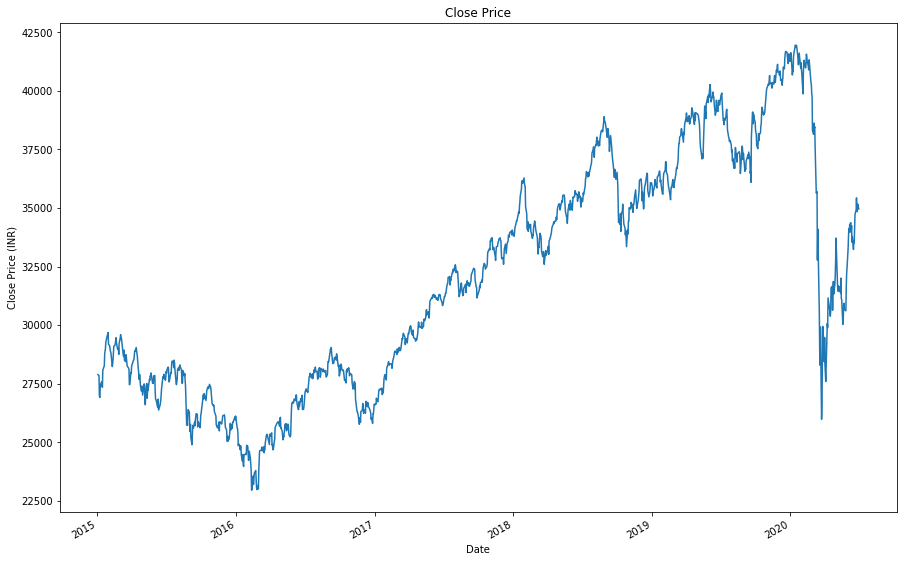

In [31]:
#Setting plot size and labels
plt.figure(figsize=(15,10))

stock_data['Close'].plot()


plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price (INR)')

In [32]:
# calculating 7 day rolling mean
stock_data.rolling(7).mean().head(20)

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-12,27420.694754,-0.713771,0.124000,0.785000,0.090857,27469.169643,27599.604353,27223.514230,9957.142857
2015-01-13,27354.670480,-0.713714,0.122857,0.785571,0.091429,27482.066964,27561.421317,27195.702846,10014.285714
2015-01-14,27283.884766,-0.714257,0.124143,0.784857,0.090857,27404.025670,27482.608538,27112.331473,10157.142857
2015-01-15,27439.326172,-0.714229,0.127286,0.776571,0.095857,27423.587054,27553.419922,27221.851283,10528.571429


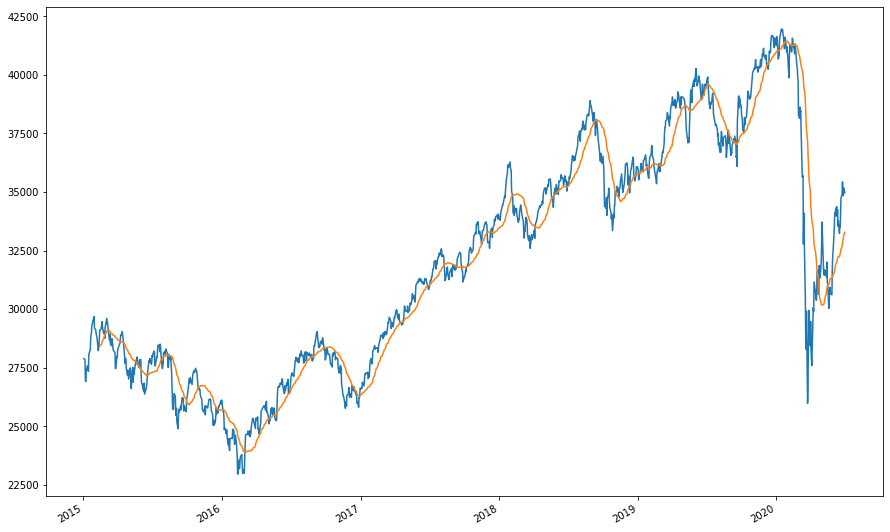

In [33]:
# setting figure size
plt.figure(figsize=(15,10))

# plotting the close price and a 30-day rolling mean of close price
stock_data['Close'].plot()
stock_data.rolling(window=30).mean()['Close'].plot()

In [34]:
# displaying stock_data
stock_data

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2015-01-02,27887.900391,-0.9995,0.131,0.766,0.103,27521.279297,27937.470703,27519.259766,7400.0
2015-01-05,27842.320312,-0.9957,0.118,0.773,0.109,27978.429688,28064.490234,27786.849609,9200.0
2015-01-06,26987.460938,-0.9995,0.100,0.833,0.067,27694.230469,27698.929688,26937.060547,14100.0
2015-01-07,26908.820312,-0.9999,0.147,0.772,0.080,26983.429688,27051.599609,26776.119141,12200.0
2015-01-08,27274.710938,-0.9999,0.134,0.798,0.068,27178.769531,27316.410156,27101.939453,8200.0
...,...,...,...,...,...,...,...,...,...
2020-06-23,35430.429688,-0.9999,0.141,0.787,0.073,35015.730469,35482.160156,34843.691406,25200.0
2020-06-24,34868.980469,-0.9997,0.116,0.808,0.075,35679.738281,35706.550781,34794.929688,26600.0
2020-06-25,34842.101562,-0.9999,0.130,0.816,0.054,34525.390625,35081.609375,34499.781250,24600.0
2020-06-26,35171.269531,-0.9999,0.150,0.765,0.085,35144.781250,35254.878906,34910.339844,24800.0


In [35]:
# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 1075
Number of records in Test Data: 270


In [36]:
# predicting one step ahead
steps_to_predict = 1


close_price = stock_data.iloc[start:total_data,0] #close
compound = stock_data.iloc[start:total_data,1] #compound
negative = stock_data.iloc[start:total_data,2] #neg
neutral = stock_data.iloc[start:total_data,3] #neu
positive = stock_data.iloc[start:total_data,4] #pos
open_price = stock_data.iloc[start:total_data,5] #open
high = stock_data.iloc[start:total_data,6] #high
low = stock_data.iloc[start:total_data,7] #low
volume = stock_data.iloc[start:total_data,8] #volume

# printing close price
print("Close Price:")
close_price

Close Price:


2015-01-05    27842.320312
2015-01-06    26987.460938
2015-01-07    26908.820312
2015-01-08    27274.710938
2015-01-09    27458.380859
                  ...     
2020-06-23    35430.429688
2020-06-24    34868.980469
2020-06-25    34842.101562
2020-06-26    35171.269531
2020-06-29    34961.519531
Name: Close, Length: 1344, dtype: float64

In [37]:

# shifting next day close
close_price_shifted = close_price.shift(-1) 

# shifting next day compound
compound_shifted = compound.shift(-1) 

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

# dropping nulls
data = data.dropna()    
data.head(10)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
2015-01-05,27842.320312,26987.460938,-0.9957,-0.9995,9200.0,27978.429688,28064.490234,27786.849609
2015-01-06,26987.460938,26908.820312,-0.9995,-0.9999,14100.0,27694.230469,27698.929688,26937.060547
2015-01-07,26908.820312,27274.710938,-0.9999,-0.9999,12200.0,26983.429688,27051.599609,26776.119141
2015-01-08,27274.710938,27458.380859,-0.9999,-0.9998,8200.0,27178.769531,27316.410156,27101.939453
2015-01-09,27458.380859,27585.269531,-0.9998,0.9979,11100.0,27404.189453,27507.669922,27119.630859
2015-01-12,27585.269531,27425.730469,0.9979,-0.9991,7500.0,27523.859375,27620.660156,27323.740234
2015-01-13,27425.730469,27346.820312,-0.9991,-0.9995,7800.0,27611.560547,27670.189453,27324.580078
2015-01-14,27346.820312,28075.550781,-0.9995,-0.9993,10200.0,27432.140625,27512.800781,27203.250000
2015-01-15,28075.550781,28121.890625,-0.9993,-0.9995,16700.0,27831.160156,28194.609375,27703.699219
2015-01-16,28121.890625,28262.009766,-0.9995,-0.9968,12100.0,28056.609375,28176.099609,27945.310547


In [38]:
#close price shifted set as the target var
y = data['close_price_shifted']
y

2015-01-05    26987.460938
2015-01-06    26908.820312
2015-01-07    27274.710938
2015-01-08    27458.380859
2015-01-09    27585.269531
                  ...     
2020-06-22    35430.429688
2020-06-23    34868.980469
2020-06-24    34842.101562
2020-06-25    35171.269531
2020-06-26    34961.519531
Name: close_price_shifted, Length: 1343, dtype: float64

In [39]:

# setting the features dataset for prediction  
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
2015-01-05,27842.320312,-0.9957,-0.9995,9200.0,27978.429688,28064.490234,27786.849609
2015-01-06,26987.460938,-0.9995,-0.9999,14100.0,27694.230469,27698.929688,26937.060547
2015-01-07,26908.820312,-0.9999,-0.9999,12200.0,26983.429688,27051.599609,26776.119141
2015-01-08,27274.710938,-0.9999,-0.9998,8200.0,27178.769531,27316.410156,27101.939453
2015-01-09,27458.380859,-0.9998,0.9979,11100.0,27404.189453,27507.669922,27119.630859
...,...,...,...,...,...,...,...
2020-06-22,34911.320312,-0.9997,-0.9999,25100.0,34892.031250,35213.519531,34794.398438
2020-06-23,35430.429688,-0.9999,-0.9997,25200.0,35015.730469,35482.160156,34843.691406
2020-06-24,34868.980469,-0.9997,-0.9999,26600.0,35679.738281,35706.550781,34794.929688
2020-06-25,34842.101562,-0.9999,-0.9999,24600.0,34525.390625,35081.609375,34499.781250


In [40]:
from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

In [41]:
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

(array([[-0.4852332 , -0.99569978, -0.99949997, ..., -0.48777388,
         -0.48548927, -0.45315894],
        [-0.57521461, -0.99949997, -0.99989999, ..., -0.51737394,
         -0.52370601, -0.54096666],
        [-0.58349222, -0.99989999, -0.99989999, ..., -0.59140563,
         -0.59137975, -0.55759655],
        ...,
        [ 0.25438414, -0.99969998, -0.99989999, ...,  0.31433676,
          0.31343357,  0.27097787],
        [ 0.2515549 , -0.99989999, -0.99989999, ...,  0.19410855,
          0.24810041,  0.24048053],
        [ 0.28620271, -0.99989999, -0.99969998, ...,  0.25861964,
          0.26621451,  0.28290307]]),
 array([[-0.57521461],
        [-0.58349222],
        [-0.54497904],
        ...,
        [ 0.2515549 ],
        [ 0.28620271],
        [ 0.26412469]]))

In [42]:

# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in Training set X: (1075, 7) and y: (1075, 1)
Number of rows and columns in Test set X: (267, 7) and y: (267, 1)


In [43]:
#reshaping dataset

print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (1075, 7)
Shape of Test set X: (267, 7)


In [44]:
from sklearn.tree import DecisionTreeRegressor
dec_tree = DecisionTreeRegressor()
dec_tree.fit(X_train, y_train)
predictions = dec_tree.predict(X_test)

In [45]:
print(predictions[:10])
print(y_test[:10])
print(mean_squared_error(predictions,y_test))

[0.68603129 0.70397585 0.70397585 0.70397585 0.70397585 0.70397585
 0.70397585 0.685343   0.70397585 0.70397585]
[[0.73496797]
 [0.76113216]
 [0.7681257 ]
 [0.74205525]
 [0.776782  ]
 [0.76438573]
 [0.82263821]
 [0.80326197]
 [0.74496755]
 [0.75403871]]
0.01762034747241149


In [46]:
lgb = lightgbm.LGBMRegressor()
lgb.fit(X_train, y_train)

LGBMRegressor()

In [47]:
predictions = lgb.predict(X_test)
print(mean_squared_error(predictions,y_test))

0.020149058977652765


In [48]:
xgb = xgboost.XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [49]:

predictions = xgb.predict(X_test)
print(mean_squared_error(predictions,y_test))

0.019731801554565314


In [50]:
adb = AdaBoostRegressor()
adb.fit(X_train, y_train)
predictions = adb.predict(X_test)

In [51]:
print(mean_squared_error(predictions, y_test))

0.030086293621476887


In [52]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm

In [53]:
# CODE HERE
model = Sequential()

# Choose whatever number of layers/neurons you want.

# https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

# Remember to compile()

In [54]:
model = Sequential()

# https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw


# input layer
model.add(Dense(78,  activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(39, activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(19, activation='relu'))
model.add(Dropout(0.2))

# output layer
model.add(Dense(units=1,activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam')

In [55]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=25,
          batch_size=256,
          validation_data=(X_test, y_test), 
          )

Train on 1075 samples, validate on 267 samples
Epoch 1/25
1075/1075 [==============================] - 1s 945us/sample - loss: 0.6374 - val_loss: 0.6807
Epoch 2/25
1075/1075 [==============================] - 0s 74us/sample - loss: 0.5004 - val_loss: 0.6910
Epoch 3/25
1075/1075 [==============================] - 0s 91us/sample - loss: 0.3834 - val_loss: 0.7040
Epoch 4/25
1075/1075 [==============================] - 0s 92us/sample - loss: 0.2610 - val_loss: 0.7127
Epoch 5/25
1075/1075 [==============================] - 0s 94us/sample - loss: 0.1176 - val_loss: 0.7199
Epoch 6/25
1075/1075 [==============================] - 0s 84us/sample - loss: -0.0487 - val_loss: 0.7236
Epoch 7/25
1075/1075 [==============================] - 0s 91us/sample - loss: -0.2272 - val_loss: 0.7259
Epoch 8/25
1075/1075 [==============================] - 0s 93us/sample - loss: -0.4410 - val_loss: 0.7237
Epoch 9/25
1075/1075 [==============================] - 0s 89us/sample - loss: -0.6860 - val_loss: 0.7125
Epo

In [56]:
from tensorflow.keras.models import load_model

In [57]:
losses = pd.DataFrame(model.history.history)

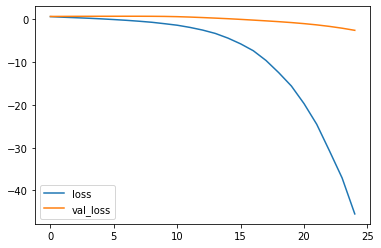

In [58]:
losses[['loss','val_loss']].plot()

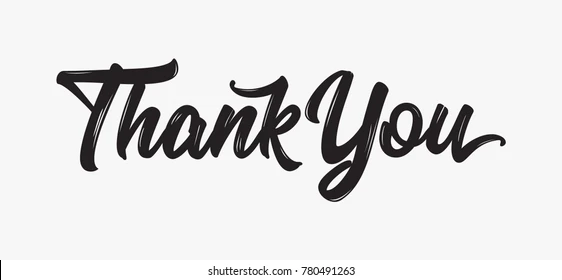